## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F
from scipy.signal import convolve2d

In [4]:
# for getting summary info on models
from torchsummary import summary

In [5]:
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

## 2. Import the data

### (i) FMNIST Dataset

In [6]:
# import dataset (comes with colab!)
fmnist = pd.read_csv("Fmnist.csv")

#### Label	Description
       0	T-shirt/top
       1	Trouser
       2	Pullover
       3	Dress
       4	Coat
       5	Sandal
       6	Shirt
       7	Sneaker
       8	Bag
       9	Ankle Boot

In [7]:
fmnist["Class"].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: Class, dtype: int64

In [8]:
fmnist.shape

(60000, 785)

In [9]:
fmnist.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2,0,0,0,0,0,0,0,5,0,0,...,0,0,30,43,0,0,0,0,0,6
3,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [10]:
# Sampling
#data = data.sample(20000, random_state=123)

data_fmnist = fmnist.to_numpy()

# Extracting only the first 8
labels_fmnist = data_fmnist[:,-1]
data_fmnist   = data_fmnist[:,:-1]

# normalize the data to a range of [0 1]
# Although T.ToTensor() will internally do the Min-Max scaling
data_fmnist = data_fmnist / np.max(data_fmnist)

# Reshape to 2D!
# number of images : data.shape[0]
# number of input channel : 1
# height : 28
# width :  28
data_fmnist = data_fmnist.reshape(data_fmnist.shape[0],1,28,28)

In [11]:
# check sizes
print(data_fmnist.shape)
print(labels_fmnist.shape)

(60000, 1, 28, 28)
(60000,)


In [12]:
labels_fmnist

array([2, 9, 6, ..., 8, 8, 7], dtype=int64)

## 3. Create DataLoader

### (A) FMNIST

#### (i) convert to tensor

In [13]:
data_fmnistT   = torch.tensor( data_fmnist ).float()
labels_fmnistT = torch.tensor( labels_fmnist ).long()

#### (ii) Train-Test split

In [14]:
fmnisttrain_data,fmnisttest_data, fmnisttrain_labels,fmnisttest_labels = train_test_split(data_fmnistT, labels_fmnistT, test_size=.15)

#### (iii) Convert into PyTorch Datasets

In [15]:
train_dataset_fmnist = TensorDataset(fmnisttrain_data, fmnisttrain_labels)
test_dataset_fmnist  = TensorDataset(fmnisttest_data, fmnisttest_labels)

#### (iv) Translate into dataloader objects

In [16]:
batchsize    = 32

train_loader_fmnist = DataLoader(train_dataset_fmnist, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader_fmnist  = DataLoader(test_dataset_fmnist,  batch_size=test_dataset_fmnist.tensors[0].shape[0])

In [17]:
# check size (should be No. of images x No. of channels x width X height)
train_loader_fmnist.dataset.tensors[0].shape

torch.Size([51000, 1, 28, 28])

In [18]:
data_fmnistT.shape

torch.Size([60000, 1, 28, 28])

In [19]:
data_fmnistT.shape.numel()

47040000

In [20]:
data_fmnistT.shape[0]

60000

In [21]:
data_fmnistT.shape.numel()/data_fmnistT.shape[0]

784.0

## 4.  Autoencoder 

#### (i) AE Model Building

In [22]:
# create a class for the model
def makeTheAENet(LR, printtoggle=False):

    class aenet(nn.Module):
        
        def __init__(self,printtoggle):
            
            super().__init__()

            # print toggle
            self.print = printtoggle

            ### -------------- Encoder layers -------------- ###
            # first convolution layer
            self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
            # output size: (28+2*1-3)/2 + 1 = 14

            # second convolution layer
            self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
            # output size: (14+2*1-3)/2 + 1 = 7


            ### -------------- Decoder layers -------------- ###
            # first convolution layer
            self.decconv1  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
            # output size: (28+2*1-3)/2 + 1 = 14

            # second convolution layer
            self.decconv2  = nn.ConvTranspose2d(16,1,4,padding=1,stride=2)
            # output size: (14+2*1-3)/2 + 1 = 7


        def forward(self,x):

            if self.print: print(f'Input: {list(x.shape)}')

            # First encoder layer
            x = F.leaky_relu( self.encconv1(x) )
            if self.print: print(f'First encoder layer: {list(x.shape)}')

            # Second encoder layer
            x = F.leaky_relu( self.encconv2(x) )
            if self.print: print(f'Second encoder layer: {list(x.shape)}')

            # First decoder layer
            x = F.leaky_relu( self.decconv1(x) )
            if self.print: print(f'First decoder layer: {list(x.shape)}')

            # Second decoder layer
            x = F.leaky_relu( self.decconv2(x) )
            if self.print: print(f'Second decoder layer: {list(x.shape)}')

            return x

    # create the model instance
    net = aenet(printtoggle)

    # loss function
    lossfunc = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=LR)

    return net, lossfunc, optimizer

##### Testing on some data

In [23]:
# test the model with one batch
testnet,testlossfun,testoptimizer = makeTheAENet(LR=0.001, printtoggle=False)

X_test,y_test = next(iter(train_loader_fmnist))
X_Hat = testnet(X_test)

# check size of output
print('\nOutput size:')
print(X_Hat.shape)

# # now let's compute the loss
loss = testlossfun(X_Hat, X_test)
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 1, 28, 28])
 
Loss:
tensor(0.2023, grad_fn=<MseLossBackward0>)


#### (ii) AE Model Training

In [24]:
def function2trainTheModel(Model, lossfunc, optimizer, train_loader, test_loader, epochs):

    #losses   = torch.zeros(epochs)
    trainloss = torch.zeros(epochs)
    testloss  = torch.zeros(epochs)

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        # batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,X)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            #matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            #matchesNumeric = matches.float()             # convert to numbers (0/1)
            #accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            #batchAcc.append( accuracyPct )               # add to list of accuracies
        # End of batch loop...

        # Get average losses across the batches
        trainloss[epochi] = np.round(np.mean(batchLoss),2)


        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            
            yHat_test = Model(X)
            loss = lossfunc(yHat_test,X)
            
        # and get average losses 
        testloss[epochi] = loss.item()


    # function output
    return trainloss,testloss,Model

#### (iii)  Run the AE model 

In [25]:
AE_model1,lossfunc1,optimizer1 = makeTheAENet(LR=0.001, printtoggle=False)

In [26]:
# took 5mins 
Trainloss1,Testloss1,trained_model1=  function2trainTheModel(Model=AE_model1 , 
                                                             lossfunc=lossfunc1 , 
                                                             optimizer=optimizer1,
                                                             train_loader=train_loader_fmnist , 
                                                             test_loader=test_loader_fmnist, 
                                                             epochs=10)

#### (iv) AE model training Results Visualization - FMNIST

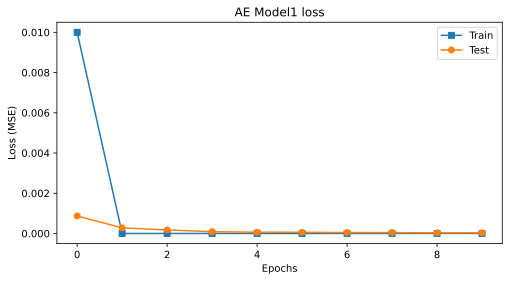

In [27]:
fig = plt.figure(figsize=(8,4), dpi=135)

plt.plot(Trainloss1,'s-',label='Train')
plt.plot(Testloss1,'o-',label='Test')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.title('AE Model1 loss')
plt.legend()

plt.show()

#### (v) AE Model prediction

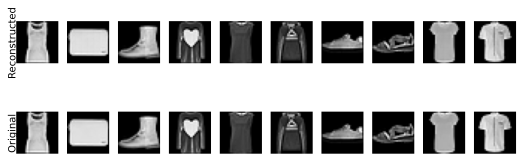

In [28]:
## show some random examples

# get some data
X,y = next(iter(test_loader_fmnist))

# forward pass and loss
trained_model1.eval() # switch to test mode
yHat = trained_model1(X)

fig,axs = plt.subplots(2,10, figsize=(9,3), dpi=135)

for i in range(10):
    
    pic = yHat[i,0,:,:].detach()
    pic = pic/2 + .5 # undo normalization
    
    axs[0,i].imshow(pic,cmap='gray')
    axs[0,i].axis('off')

    pic = X[i,0,:,:].detach()
    pic = pic/2 + .5 # undo normalization
    
    axs[1,i].imshow(pic,cmap='gray')
    axs[1,i].axis('off')

    if i==0:
        axs[0,0].text(-6,14,'Reconstructed',rotation=90,va='center')
        axs[1,0].text(-6,14,'Original',rotation=90,va='center')

  
plt.show()

## 5. Classification Model

#### (i)  Create the classification model

In [31]:
# create a class for the model
def createTheFMNISTNet(LR, printtoggle=False):

    class fmnistNet(nn.Module):
        
        def __init__(self,printtoggle):
            super().__init__()

            ### convolution layers 
            # 1:in_channels (gray scale) , 16:out_channels, stride=2
            self.conv1 = nn.Conv2d( 1,16,kernel_size=3,stride=2,padding=1)
            # since, it's a square image, therefore row_size = column_size
            # size: (28+2*1-3)/2 + 1 = 14

            self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
            # size: (14+2*1-3)/1 + 1 = 14

            ### fully-connected layer
            # 50 : number of Neurons
            # input_features = 14*14*32
            self.fc1 = nn.Linear(14*14*32,50)

            ### output layer
            self.out = nn.Linear(50,10)

            # toggle for printing out tensor sizes during forward prop
            self.print = printtoggle

        # forward pass
        def forward(self,x):

            print(f'Input: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu
            x = F.leaky_relu( self.conv1(x) )
            print(f'Layer conv1: {x.shape}') if self.print else None

            # Again: convolution -> maxpool -> relu
            x = F.leaky_relu( self.conv2(x) )
            print(f'Layer conv2 : {x.shape}') if self.print else None

            # reshape for linear layer
            # torch.numel(input) : Returns the total number of elements in the input tensor.
            nUnits = x.shape.numel()/x.shape[0]

            # Reshaping
            x = x.view(-1,int(nUnits))

            if self.print: print(f'Vectorize : {x.shape}')

            # linear layers
            x = F.relu( self.fc1(x) )
            if self.print: print(f'Layer fc1: {x.shape}')

            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x
  
    # create the model instance
    model = fmnistNet(printtoggle)

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=LR)

    return model, lossfunc, optimizer

##### Testing the shapes at each layer

In [32]:
# test the model with one batch
test_net, test_lossfun, test_optimizer = createTheFMNISTNet(LR=0.001,printtoggle=True)

X,y = next(iter(train_loader_fmnist))
yHat = test_net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = test_lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

# 32 : batch size

Input: torch.Size([32, 1, 28, 28])
Layer conv1: torch.Size([32, 16, 14, 14])
Layer conv2 : torch.Size([32, 32, 14, 14])
Vectorize : torch.Size([32, 6272])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3399, grad_fn=<NllLossBackward0>)


#### (ii)  classification Model Training

In [33]:
def function2trainTheModel(Model, lossfunc, optimizer, train_loader, test_loader, epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,testAcc,losses,Model

#### (iii) Run the classification model 

In [34]:
model_fmnist,lossfunc_fmnist,optimizer_fmnist = createTheFMNISTNet(LR=0.001, printtoggle=False)

In [35]:
# took 7mins
TrainAcc_fmnist,TestAcc_fmnist,Losses_fmnist,trained_clf_Model1=function2trainTheModel(Model=model_fmnist , 
                                                                     lossfunc=lossfunc_fmnist , 
                                                                     optimizer=optimizer_fmnist,
                                                                     train_loader=train_loader_fmnist , 
                                                                     test_loader=test_loader_fmnist, 
                                                                     epochs=10)

#### (iv) Results Visualization - fmnist

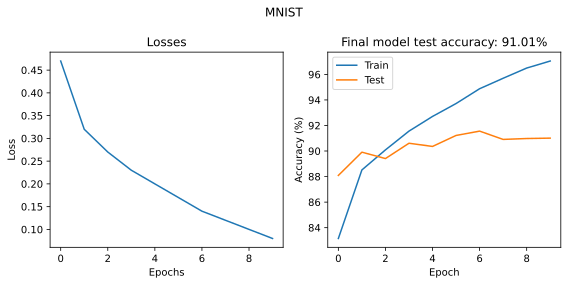

In [36]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(Losses_fmnist.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses')

ax[1].plot(TrainAcc_fmnist,label='Train')
ax[1].plot(TestAcc_fmnist, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Final model test accuracy: {TestAcc_fmnist[-1]:.2f}%')

ax[1].legend()
fig.suptitle("MNIST")
fig.tight_layout()

plt.show()

## 6. Transfer learning

#### (i) 

In [37]:
model_TL, lossfunc_TL, optimizer_TL = createTheFMNISTNet(LR=0.001, printtoggle=False)

#### (ii) Transfer learning in action

In [38]:
import copy

In [39]:
# trained_model1 : is a trained AE model 
# for zip function to work, both models must have equal number of layers.

for target, source in zip(model_TL.named_parameters(), trained_model1.named_parameters() ):
    
    print('Model TL: ' + target[0] + '   |   Trained AE model ' + source[0])
    
    if 'conv' in target[0]:
        target[1].data = copy.deepcopy( source[1].data )

Model TL: conv1.weight   |   Trained AE model encconv1.weight
Model TL: conv1.bias   |   Trained AE model encconv1.bias
Model TL: conv2.weight   |   Trained AE model encconv2.weight
Model TL: conv2.bias   |   Trained AE model encconv2.bias
Model TL: fc1.weight   |   Trained AE model decconv1.weight
Model TL: fc1.bias   |   Trained AE model decconv1.bias
Model TL: out.weight   |   Trained AE model decconv2.weight
Model TL: out.bias   |   Trained AE model decconv2.bias


#### (iii) Model training with TL

In [40]:
TrainAcc_TL,TestAcc_TL,Losses_TL,trained_clf_Model_TL=function2trainTheModel(Model=model_TL , 
                                                                     lossfunc=lossfunc_TL , 
                                                                     optimizer=optimizer_TL,
                                                                     train_loader=train_loader_fmnist , 
                                                                     test_loader=test_loader_fmnist, 
                                                                     epochs=10)

#### (iv) Results Visualization

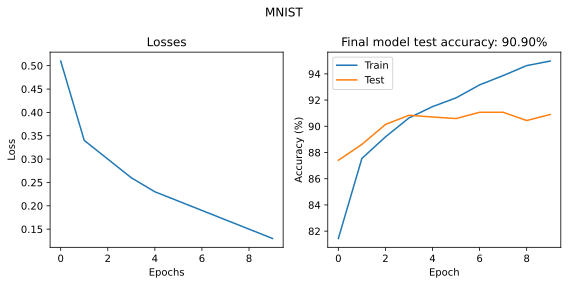

In [41]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(Losses_TL.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses')

ax[1].plot(TrainAcc_TL,label='Train')
ax[1].plot(TestAcc_TL, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Final model test accuracy: {TestAcc_TL[-1]:.2f}%')

ax[1].legend()
fig.suptitle("MNIST")
fig.tight_layout()

plt.show()